# Function for GPR Plot
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Sofia Ingersoll

This is the list of the **top 10 most common variables:**


GPP, NBP, TOTVEGC, TLAI, EFLX_LH_TOT, SOILWATER_10CM, QRUNOFF, FSR, FAREA_BURNED, SNOWDP

In [1]:
# moved the libraries that were here into ml_utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel
from sklearn.metrics.pairwise import linear_kernel as Linear
import gpflow                                                          # conda not found, sent message via slack
import tensorflow as tf

2024-03-28 11:57:41.174266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# import libraries & data pre-processing functions from utils.py
from ml_utils import *

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

/glade/u/home/hmchilders/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42209 instead
  warnings.warn(


In [4]:
# apply peer2peer network communication across multiple devices
client.cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/42209/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.118:32967,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hmchilders/proxy/42209/status,Total threads: 0
Started: Just now,Total memory: 0 B


Prepare the data for GPR, including selecting the target variable and 32 parameters as features.

Split the data into training and testing sets.

Define a grid of hyperparameters for the GPR model.

Perform grid search cross-validation to find the best hyperparameters.

Fit the GPR model using the best hyperparameters on the training data.

Generate predictions and confidence intervals for each variable using the trained model.

Plot the results, including the observed data, predicted values, and confidence intervals.

### Reshaping Parameter xr.ds into np.array

In [5]:
param_avg = params

In [6]:
param_avg

<xarray.Dataset> Size: 132kB
Dimensions:              (member: 500)
Coordinates:
  * member               (member) object 4kB 'LHC0001' 'LHC0002' ... 'LHC0500'
Data variables: (12/32)
    FUN_fracfixers       (member) float64 4kB 0.7783 0.3193 ... 0.2621 0.4221
    KCN                  (member) float64 4kB 0.358 0.5488 ... 0.9123 0.8392
    a_fix                (member) float64 4kB 0.255 0.6302 ... 0.5339 0.1443
    crit_dayl            (member) float64 4kB 0.4012 0.27 ... 0.9974 0.6571
    d_max                (member) float64 4kB 0.7978 0.5361 ... 0.9076 0.4009
    fff                  (member) float64 4kB 0.1301 0.6792 ... 0.9918 0.02798
    ...                   ...
    stem_leaf            (member) float64 4kB 0.1138 0.1273 ... 0.3328 0.347
    sucsat_sf            (member) float64 4kB 0.7982 0.3947 ... 0.3526 0.6515
    theta_cj             (member) float64 4kB 0.03646 0.09374 ... 0.8429 0.5055
    tpu25ratio           (member) float64 4kB 0.3936 0.04108 ... 0.716 0.2124
    tpuse_sf             (member) float64 4kB 0.07896 0.2756 ... 0.353 0.3634
    wc2wjb0              (member) float64 4kB 0.6846 0.8785 ... 0.3581 0.1567

In [7]:
# Reshape param_avg into a numpy array with shape (500, 32)
param_values = param_avg.to_array().values

# each row represents a simulation and each column represents a parameter
param_reshaped = param_values.reshape(500, -1)

# confirm output is (500, 32)
param_reshaped.shape

(500, 32)

### Variable Selection

**Working to bolster this section to standardize non-gaussian variables like precipitation piror to gpr**

In [8]:
da = subset_var_cluster('LNC')

In [9]:
# only runs once, then outputs an error -- add a cute message to shorten warning
var_avg = wrangle_var_cluster(da)

# what's going on here? let's check the shape!
var_avg.shape

# for dashboard, include line to save output as a file to call later
# ifelse statement to either create file or read in

(500,)

In [10]:
var_avg

<xarray.DataArray (ens: 500)> Size: 4kB
dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: ens

In [11]:
var_reshaped = var_avg.values.reshape(-1, 1)

var_reshaped.shape

(500, 1)

#### Split the data

In [12]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# data for splitting
X_train, X_test, y_train, y_test = train_test_split(param_reshaped,
                                                    var_reshaped,
                                                    test_size=0.1,
                                                    # setting a seed
                                                    random_state=0)

## Custom Kernel & Hyperparameter Grid Tuning
The tune grid chunk is what I'm working to implement within our workflow, so we can optimize hyperparameters as we train our model

Using Linnia's Code & Advice

**Brainstorming idea**:

Since we're building a pickeled model (archiving the most interesting relationships) we could try and optimize what model configuration is applied to assess uncertainty.


**It would be cool to create a model that contains a collection of custom kernels that are tested for a relationship, the model then evaluates the different metrics output by the custom kernels applied and chooses the model with the best metric to plot**

In [13]:
# load parameter sets 
lhckey = '/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt'
df = pd.read_csv(lhckey)
lhc_params = df.drop(columns='member')
num_params = len(lhc_params.columns)

num_params

32

In [14]:
param_reshaped.shape

(500, 32)

In [15]:
# pre-kernel prep
num_params = param_reshaped.shape[1]

num_params

32

#### Kernel Specs

#### sklearn

In [16]:
# Define kernel components with the same configurations as in GPflow
linear = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=np.ones(num_params))
poly = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=np.ones(num_params))

# RBF kernel in GPflow is equivalent to scikit-learn's RBF kernel
RBF = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) * RBF(length_scale=np.ones(num_params))

# Matern32 in GPflow is equivalent to scikit-learn's Matern with nu=1.5
Matern32 = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) * Matern(length_scale=np.ones(num_params), nu=1.5)

# Matern52 in GPflow is equivalent to scikit-learn's Matern with nu=2.5
Matern52 = ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-3, 1e3)) * Matern(length_scale=np.ones(num_params), nu=2.5)

# Bias kernel in GPflow is equivalent to scikit-learn's WhiteKernel
bias = WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-3, 1e3))

NameError: name 'ConstantKernel' is not defined

#### gpflow

In [17]:
# Defining kernel components
linear = gpflow.kernels.Linear(active_dims=range(num_params), variance=[1.]*num_params) 
poly = gpflow.kernels.Polynomial(active_dims=range(num_params), variance=[1.]*num_params) 

RBF = gpflow.kernels.RBF(active_dims = range(num_params), lengthscales=np.tile(1,num_params))

# need to play around this these settings to be certain
# the larger the number, the smoother the best fit line (tech doc more info)
Matern32 = gpflow.kernels.Matern32(active_dims=range(num_params), lengthscales=np.tile(1,num_params))
Matern52 = gpflow.kernels.Matern52(active_dims=range(num_params), lengthscales=np.tile(1,num_params))

bias = gpflow.kernels.Bias(active_dims=range(num_params)) 

#### Custom Kernel Recipes
Working to write kernels catered for vegetation, atmospheric, hydrological, and soil data.

In [43]:
canopy_kernel = linear + RBF + poly + bias

In [44]:
grass_kernel = linear * RBF  + Matern32 + bias

In [27]:
soil_kernel_1 = Matern32 + bias

In [29]:
soil_kernel_2 = Matern52 + bias

In [45]:
soil_kernel_3 = linear + Matern32 + bias

In [46]:
soil_kernel_4 = linear + Matern52 + bias

In [47]:
soil_kernel_5 = linear * Matern32 + bias

In [48]:
soil_kernel_6 = linear * Matern52 + bias

#### Making a Custom Kernel Collection
The thought process behind this is to try and create an all encompassing gpr model, seeing that our data spans a broad spectrum of environmental components.

I'm researching publications for Atmospheric, Soil, Vegetation, and Hydrological Data to use here. I've started a document of these pubs. in our google drive, we can reference these in our tech. docs.


The kernels are current under construction so there are significantly more in this early version. The plan is to reduce this down to ~4-5 kernels

In [90]:
# Define a collection of soil related kernels
kernel_collection = [
    (soil_kernel_1, "Kernel 1 under construction -- soil data"),
    (soil_kernel_2, "Kernel 2 under construction -- soil data"),
    (soil_kernel_3,"Kernel 3 under construction -- soil data"),
    (soil_kernel_4, "Kernel 4 under construction -- soil data"),
    (soil_kernel_5, "Kernel 5 under construction -- soil data"),
    (soil_kernel_5, "Kernel 6 under construction -- soil data")
    # Add more kernels as needed
]

In [ ]:
# Define a collection of kernels
kernel_collection = [
    (canopy_kernel, "Kernel that's optimized for tree related data"),
    (grass_kernel, "Kernel that's optimized for grass related data"),
    (atmo_kernel, "Kernel under construction -- atmospheric data"),
    (soil_kernel_1, "Kernel under construction -- soil data"),
    (soil_kernel_2, "Kernel under construction -- soil data"),
    (soil_kernel_3,"Kernel under construction -- soil data")
    # Add more kernels as needed
]

#### Training Emulator

Brainstorming idea:

Since we're building a pickeled model (archiving the most interesting relationships) we could try and optimize what model configuration is applied to assess uncertainty.


**It would be cool to create a model that contains a collection of custom kernels that are tested for a relationship, the model then evaluates the different metrics output by the custom kernels applied and chooses the model with the best metric to plot**

In [ ]:
# Code taken from Linnia to build off of
# define the GPR model 
model = gpflow.models.GPR(data=(X_train, y_train), kernel=kernel, mean_function=None)
# set the optimization althorithm (using Lbfgs)
# need to look into ADAM as well
opt = gpflow.optimizers.Scipy() # select the optimization algorithm (using: lBFGS)
# train the GPR model
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=500))

#### Saving Model Metrics
Plan on adjusting this to store in a combined df for each kernel spec

In [ ]:
# Code taken from Linnia to build off of
# save model predictions with tensorflow
model.predict = tf.function(model.predict_y, input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
savedir = str(f('./{var}_{param}_emulators/'))
tf.saved_model.save(model, savedir)

### Psuedocode for Kernel Selection Function

#### sklearn with gpflow converted kernels

Working on a wrapper function to convert gpflow kernels into sklearn

```
 # Convert gpflow kernel to sklearn kernel
    # Need to come up with the proper wrapper function, a mix of dot and sum
    # Will move this preprocessing outside of function
   # sklearn_kernel = Sum([kernel, some_other_kernel])  # You need to define some_other_kernel
```


In [107]:
from sklearn.gaussian_process.kernels import Sum

# Iterate through the collection and evaluate each kernel
best_kernel = None
best_rmse = float('inf')
best_r2 = -float('inf')
best_predictions = None
best_sigma = None
best_name = None


best_name = None

for kernel, name in kernel_collection:
    # Assuming kernel is from gpflow and represents a single kernel
    # You may need to combine it with another kernel to form a sum
    # For example, you can use a ConstantKernel or a RBF kernel from scikit-learn
    
    # Convert gpflow kernel to sklearn kernel
    # Need to come up with the proper wrapper function, a mix of dot and sum
    # Will move this preprocessing outside of function
   # sklearn_kernel = Sum([kernel, some_other_kernel])  # You need to define some_other_kernel
    
    # Fit GPR model
    model = GaussianProcessRegressor(kernel=sklearn_kernel, n_restarts_optimizer=20, normalize_y=True)

    # Fit the model
    model.fit(x_train, y_train)

    # Make predictions
    y_pred = model.predict(x_test)
    
    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Check if current kernel is the best-performing
    if rmse < best_rmse and r2 > best_r2:
        best_kernel = kernel
        best_rmse = rmse
        best_r2 = r2
        best_predictions = y_pred
        # No need to assign best_sigma and best_name here since they are not used
    
# Store the best-performing kernel and its evaluation metrics
best_model = GPRResult(best_kernel, best_rmse, best_r2, best_predictions, best_sigma)

# Plotting
# You can now use best_model.predictions, best_model.sigma, x_test, and y_test for plotting later.
# Store the best-performing kernel and its evaluation metrics
print("Best Name:", best_model.dictionary_name)
print("RMSE:", best_model.rmse)
print("R^2 Score:", best_model.r2)

NameError: name 'sklearn_kernel' is not defined

#### sklearn

I've included a grid search, but I'm working on fixing how the param_grid for tuning is configured in this loop so it'll run properly.

In [108]:
# Create a parameter grid
param_grid = {
    'kernel': [kernel for kernel, _ in kernel_collection],
}

# Iterate through the collection and evaluate each kernel
best_kernel = None
best_rmse = float('inf')
best_r2 = -float('inf')
best_predictions = None
best_sigma = None
best_name = None

for kernel, name in kernel_collection:
    # Fit GPR model
    model = GaussianProcessRegressor(n_restarts_optimizer=20, normalize_y=True)
    # Initialize GridSearchCV with the parameter grid
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit the model
    grid_search.fit(x_train, y_train)

    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Make predictions
    y_pred = best_model.predict(x_test)
    
    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Check if current kernel is the best-performing
    if rmse < best_rmse and r2 > best_r2:
        best_kernel = kernel
        best_rmse = rmse
        best_r2 = r2
        best_predictions = y_pred
        # No need to assign best_sigma and best_name here since they are not used
    
# Store the best-performing kernel and its evaluation metrics
best_model = GPRResult(best_kernel, best_rmse, best_r2, best_predictions, best_sigma)

# Plotting
# You can now use best_model.predictions, best_model.sigma, x_test, and y_test for plotting later.
# Store the best-performing kernel and its evaluation metrics
print("Best Name:", best_model.dictionary_name)
print("RMSE:", best_model.rmse)
print("R^2 Score:", best_model.r2)
# Access other attributes as needed

ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x1471bd369d90> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719a9bff90> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719d69e450> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x1471e6759ad0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719b31cf90> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719b9ae190> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719a9db250> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719afd0210> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x1471bdfabc10> instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719aeeb7d0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719ad3a350> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719b1a89d0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719cd8be50> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719a9c9f90> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719a9a4450> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719af133d0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x1471bd738650> instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719cc002d0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719d7d9710> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x1471bccd8b50> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719af3f450> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719b3fd010> instead.

--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719afd3f50> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719cc01cd0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x1471bd8a7850> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719aa367d0> instead.

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'kernel' parameter of GaussianProcessRegressor must be None or an instance of 'sklearn.gaussian_process.kernels.Kernel'. Got <gpflow.kernels.base.Sum object at 0x14719a8e1450> instead.


In [106]:
# Iterate through the collection and evaluate each kernel
best_kernel = None
best_rmse = float('inf')
best_r2 = -float('inf')
best_predictions = None
best_sigma = None
best_name = None

for kernel, name in kernel_collection:
    # Fit GPR model optimization algorithim defaults to Lbfgs using sklearn
    # The negative log marginal likelihood (NLML)
    # is defined internally by function and used for optimizing the model during fitting.
    model = GaussianProcessRegressor(n_restarts_optimizer=20, normalize_y=True)
    # set the)
    # scoring in scikit-learn uses (-) convention to reflect lower MSE = better metrics
    grid_search = GridSearchCV(model, kernel_collection, cv=5, scoring='neg_mean_squared_error')

    grid_search.fit(x_train, y_train)

    # Make predictions
    y_pred, sigma = gpr.predict(x_test, return_std=True)
    
    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Check if current kernel is the best-performing
    if rmse < best_rmse and r2 > best_r2:
        best_kernel = kernel
        best_rmse = rmse
        best_r2 = r2
        best_predictions = y_pred
        best_sigma = sigma
        best_name = name

# Store the best-performing kernel and its evaluation metrics
class GPRResult:
    def __init__(self, kernel, rmse, r2, predictions, sigma):
        self.kernel = kernel
        self.rmse = rmse
        self.r2 = r2
        self.predictions = predictions
        self.sigma = sigma

best_model = GPRResult(best_kernel, best_rmse, best_r2, best_predictions, best_sigma)

# Plotting
# You can now use best_model.predictions, best_model.sigma, x_test, and y_test for plotting later.
# Store the best-performing kernel and its evaluation metrics
print("Best Name:", best_model.dictionary_name)
print("RMSE:", best_model.rmse)
print("R^2 Score:", best_model.r2)
# Access other attributes as needed

TypeError: Parameter grid is not a dict ((<gpflow.kernels.base.Sum object at 0x1471af48e2d0>, 'Kernel 1 under construction -- soil data'))

In [ ]:
# Code taken from Linnia to build off of, tweaked for y_test v y_pred
# plot validation
y_pred, y_pred_var = model.predict_y(X_test)
sd = y_pred_var.numpy().flatten()**0.5
    
coef_deter = r2_score(y_test.flatten(),y_pred.numpy())
    
plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=3*sd, fmt="o")
plt.text(0,np.max(y_test.flatten()),'R2_score = '+str(np.round(coef_deter,2)),fontsize=10)
plt.plot([0,np.max(y_test.flatten())],[0,np.max(y_pred)],linestyle='--',c='k')
plt.xlabel('Variable Test')
plt.ylabel('Emulated Variable')
plt.xlim([np.min(y_test.flatten())-1,np.max(y_test.flatten())+1])
plt.ylim([np.min(y_pred)-1,np.max(y_pred)+1])
plt.title('Emulator Validation')
    
plt.tight_layout()

#### gpflow 
I am working on getting the name of the best kernel to output from the dictionary, but it's not working right, just yet

In [19]:
# Iterate through the collection and evaluate each kernel
best_kernel = None
best_rmse = float('inf')
best_r2 = -float('inf')
best_predictions = None
best_sigma = None
best_name = None

for kernel, name in kernel_collection:
    # Fit GPR model
    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
    # set the optimization algorithm (using L-BFGS)
    opt = gpflow.optimizers.Scipy()
    # train the GPR model
    opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=500))
    
    # Define a TensorFlow function for making predictions
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, num_params], dtype=tf.float64)])
    def predict_fn(x):
        return model.predict_y(x)
    
    # Make predictions
    y_pred, sigma = predict_fn(x_test)
    
    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Check if current kernel is the best-performing
    if rmse < best_rmse and r2 > best_r2:
        best_kernel = kernel
        best_rmse = rmse
        best_r2 = r2
        best_predictions = y_pred
        best_sigma = sigma
        # i want this to output the name of the best kernel
        dictionary_name = dictionary_name

class GPRResult:
    def __init__(self, kernel, dictionary_name, rmse, r2, predictions, sigma):
        self.kernel = kernel
        # i want this to output the name of the best kernel
        self.dictionary_name = dictionary_name
        self.rmse = rmse
        self.r2 = r2
        self.predictions = predictions
        self.sigma = sigma

best_model = GPRResult(best_kernel, dictionary_name, best_rmse, best_r2, best_predictions, best_sigma)

# Store the best-performing kernel and its evaluation metrics
print("Best Name:", best_model.dictionary_name)
print("RMSE:", best_model.rmse)
print("R^2 Score:", best_model.r2)
# Access other attributes as needed

# Save the model using TensorFlow's SavedModel format
#savedir = './best_predictions/'
#tf.saved_model.save(model, savedir)

NameError: name 'kernel_collection' is not defined

In [18]:
# Code taken from Linnia to build off of, tweaked for y_test v y_pred
# plot validation
y_pred, y_pred_var = model.predict_y(X_test)
sd = y_pred_var.numpy().flatten()**0.5
    
coef_deter = r2_score(y_test.flatten(),y_pred.numpy())
    
plt.errorbar(y_test.flatten(), y_pred.numpy().flatten(), yerr=3*sd, fmt="o")
plt.text(0,np.max(y_test.flatten()),'R2_score = '+str(np.round(coef_deter,2)),fontsize=10)
plt.plot(0,np.max(y_test.max()),[0,np.max(y_pred)],linestyle='--',c='k')
plt.xlabel('Variable Test')
plt.ylabel('Emulated Variable')
plt.xlim([np.min(y_test.flatten())-1,np.max(y_test.flatten())+1])
plt.ylim([np.min(y_pred)-1,np.max(y_pred)+1])
plt.title('Emulator Validation')
    
plt.tight_layout()

NameError: name 'model' is not defined

In [67]:
# Iterate through the collection and evaluate each kernel
best_kernel = None
best_rmse = float('inf')
best_r2 = -float('inf')
best_predictions = None
best_sigma = None
best_name = None

for kernel, name in kernel_collection:
    # Fit GPR model
    model = gpflow.models.GPR(data=(x_train, y_train), kernel=kernel, mean_function=None)
    # Define the objective function (negative log marginal likelihood) to be minimized
    @tf.function
    def objective():
        return -model.log_marginal_likelihood()
    # Optimize the model
    gpflow.optimizers.Scipy().minimize(objective, variables=model.trainable_variables)
    
    # Make predictions
    y_pred, sigma = model.predict_y(x_test)
    
    # Evaluate model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Check if current kernel is the best-performing
    if rmse < best_rmse and r2 > best_r2:
        best_kernel = kernel
        best_rmse = rmse
        best_r2 = r2
        best_predictions = y_pred
        best_sigma = sigma
        best_name = name

# Store the best-performing kernel and its evaluation metrics
class GPRResult:
    def __init__(self, kernel, kernel_name, rmse, r2, predictions, sigma):
        self.kernel = kernel
        self.kernel_name = kernel
        self.rmse = rmse
        self.r2 = r2
        self.predictions = predictions
        self.sigma = sigma

best_model = GPRResult(best_kernel, best_name, best_rmse, best_r2, best_predictions, best_sigma)

# Plotting
# You can now use best_model.predictions, best_model.sigma, x_test, and y_test for plotting later.


In [68]:
print("Best Name:", best_model.kernel_name)
print("RMSE:", best_model.rmse)
print("R^2 Score:", best_model.r2)
# Access other attributes as needed

Best Name: <gpflow.kernels.base.Sum object at 0x1471bd947cd0>
RMSE: 0.18864519461097878
R^2 Score: 0.056628546758465625


#### Initial attempt

In [35]:
# Define a custom kernel as a combination of RBF, Matern, Noise, and Constant kernels
custom_kernel = Linear * RBF() + Matern() + WhiteKernel()

# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [custom_kernel],
    # Add more kernel configurations as needed
}

# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20).fit(X_train, y_train, normalize_y=True)

# scoring in scikit-learn uses (-) convention to reflect lower MSE = better metrics
grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)

# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

# Fit the GPR model using the best hyperparameters on the training data
gpr_best = GaussianProcessRegressor(kernel=best_kernel)
gpr_best.fit(x_train, y_train)

# Set error_score='raise' for model validation
try:
    scores = cross_val_score(gpr_model, X_train, y_train, cv=5, error_score='raise')
    print("Cross-validation scores:", scores)
except Exception as e:
    print("Error occurred during model validation:", e)

# Generate predictions for the test data
y_pred = gpr_best.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error:", rmse)
print("R² Score:", r2)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
AttributeError: 'function' object has no attribute 'log'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/base.py", line 1351, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py", line 292, in fit
    if self.optimizer is not None and self.kernel_.n_dims > 0:
                                      ^^^^^^^^^^^^^^^^^^^
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py", line 257, in n_dims
    return self.theta.shape[0]
           ^^^^^^^^^^
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py", line 731, in theta
    return np.append(self.k1.theta, self.k2.theta)
                     ^^^^^^^^^^^^^
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py", line 731, in theta
    return np.append(self.k1.theta, self.k2.theta)
                     ^^^^^^^^^^^^^
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py", line 731, in theta
    return np.append(self.k1.theta, self.k2.theta)
                     ^^^^^^^^^^^^^
  File "/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py", line 289, in theta
    return np.log(np.hstack(theta))
           ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: loop of ufunc does not support argument 0 of type function which has no callable log method


In [31]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~   
 # standard 0:1, set constant
n = 50

x_pred = np.linspace(0,1,n)

# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_test, return_std=True)     # to be included once upper portion of workflow optimized
# when plotting want to sequence along x_test

# Reshape sigma to match the shape of y_pred
sigma_reshaped = sigma.reshape(-1, 1).flatten()

sigma_reshaped.shape

NameError: name 'gpr_best' is not defined

In [22]:
# these are the 50 cross validation points
y_pred.shape

(50,)

In [65]:
x_pred.shape

(50,)

In [67]:
x_test.shape

(50, 32)

In [17]:
y_test.shape

(50, 1)

ValueError: operands could not be broadcast together with shapes (1600,) (50,) 

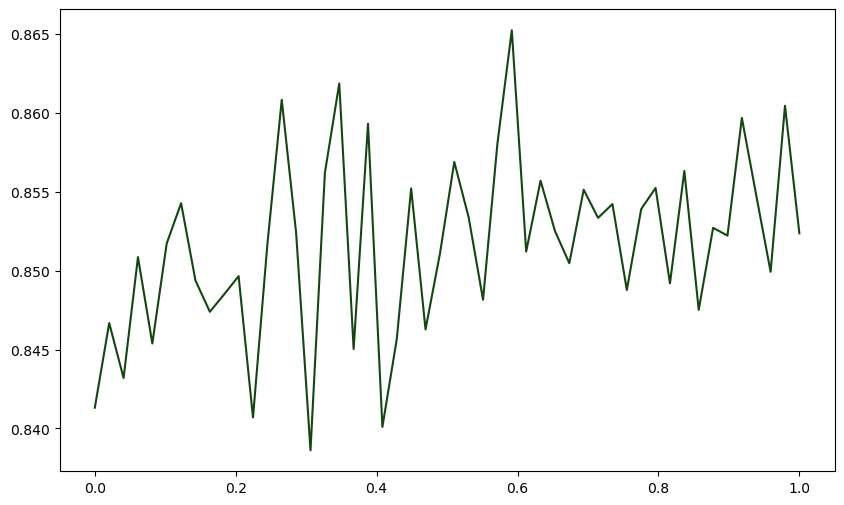

In [26]:
plt.figure(figsize=(10, 6))
#plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
# when plotting want to sequence along x_test
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma_reshaped, y_pred + 1.96 * sigma_reshaped, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

ValueError: where size (50) does not match x size (1600)

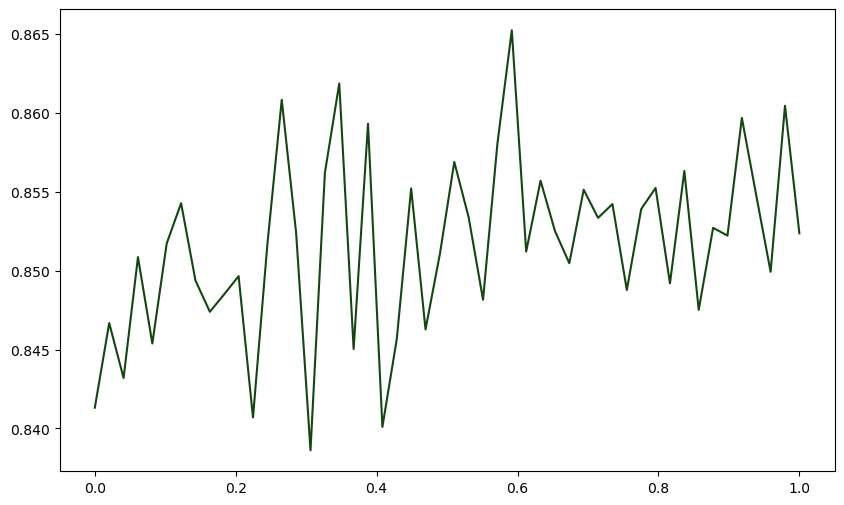

In [64]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Plot Model           ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.figure(figsize=(10, 6))
#plt.scatter(param_avg, var_avg, color='#62c900ff', label='Observed data')
plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
plt.fill_between(x_test.flatten(),
                    y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                    where=(y_pred - 1.96 * sigma <= y_pred + 1.96 * sigma),  # condition to fill between curves
                    alpha=0.5,
                    color='#9d6b53',
                    label='95% Confidence Interval')
# Set plot labels and title
plt.xlabel(f"Perturbed Parameter: ({param_avg:})")  # ideas for later: param_name = getattr(param_avg)
plt.ylabel(f"Variable: ({var_avg:})")
plt.title('Parameter Value Uncertainty Estimation')
plt.legend()
# Show the plot
plt.show()


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Plot Model           ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
    plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
    plt.fill_between(x_test.flatten(),
                     y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.5,
                     color='#9d6b53',
                     label = '95% Confidence Interval')
    # Set plot labels and title
    plt.xlabel(f"Perturbed Parameter: ({param_avg:})")  # ideas for later: param_name = getattr(param_avg)
    plt.ylabel(f"Variable: ({var_avg:})")
    plt.title('Parameter Value Uncertainty Estimation')
    plt.legend()
    # Show the plot
    plt.show()

In [ ]:
# Plot the mean line
    plt.plot(x_values, y_mean, color='blue', linestyle='-', label='Gaussian Regression Line')
    
    # Calculate the z-score for the 95% confidence interval
    z_score = norm.ppf(0.975)  # 97.5th percentile
    
    # Plot the shaded region for the 95% confidence interval
    plt.fill_between(x_test.flatten(), y_pred - z_score * y_std, y_pred + z_score * y_std, color='lightblue', alpha=0.3)
    
    # Plot the z-score value on the plot
   # plt.text(0.5, 0.5, f'95% CI (z-score: {z_score:.2f})', transform=plt.gca().transAxes, fontsize=10, verticalalignment='bottom')

# Plot the actual training data against the predicted values
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='red', label='Training Data')
gaussian_regression_line(gp_model_cv, X_train)
plt.xlabel('X_test')
plt.ylabel('Y')
plt.title('Actual Training Data vs Gaussian Regression Line with 95% Confidence Interval')
plt.legend()
plt.show()

### Ideas to build off of

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Set up Tune Grid       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [ConstantKernel(constant_value=3, constant_value_bounds=(1e-4, 1e4) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-4)],
    # Add more kernel configurations as needed
}

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Finalize Workflow       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the GPR model using the best hyperparameters on the training data
gpr_best = GaussianProcessRegressor(kernel=best_kernel)
gpr_best.fit(x_train, y_train)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_pred, return_std=True)
# standard 0:1, set constant
x_pred = np.linspace(0,1,20)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Evaluate Model         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# get accuracy of testing prediction, rmse
# get accuracy of testing prediction, rmse
y_pred_test = gpr_best.predict(x_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----  User Selected ML Plotting Funct   ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function to plot a cluster for to build on for ml
def cluster_ml_plot(param_avg, var_avg):


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit Model            ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Generate predictions and confidence intervals for each variable using the trained model
    y_pred, sigma = gpr_best.predict(x_pred, return_std=True)     # to be included once upper portion of workflow optimized
   
    # standard 0:1, set constant
    x_pred = np.linspace(0,1,20)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Plot Model           ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
    plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
    plt.fill_between(x_test.flatten(),
                     y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.5,
                     color='#9d6b53',
                     label = '95% Confidence Interval')
    # Set plot labels and title
    plt.xlabel(f"Perturbed Parameter: ({param_avg:})")  # ideas for later: param_name = getattr(param_avg)
    plt.ylabel(f"Variable: ({var_avg:})")
    plt.title('Parameter Value Uncertainty Estimation')
    plt.legend()
    # Show the plot
    plt.show()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(param_avg.values,
                                                    var_avg.values, 
                                                    test_size=0.1, 
                                                    random_state=0)

# Instantiate and fit the Gaussian Process Regression model
gpr = GaussianProcessRegressor()
gpr.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = gpr.predict(x_test)

# Evaluate the model using root mean squared error
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the RMSE
print("Root Mean Squared Error:", rmse)

### This is an area that needs to be addressed this week. However, my focus is primarily on GPR to prepare for our meeting with Linnia the Post Doc

In [ ]:
var_avg = wrangle_var_cluster(da)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(param_reshaped,
                                                    var_reshaped,
                                                    test_size=0.1,
                                                    # setting a seed
                                                    random_state=0)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----  User Selected ML Plotting Funct   ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function to plot a cluster for to build on for ml
def cluster_ml_plot(param_avg, var_avg):


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit Model            ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Generate predictions and confidence intervals for each variable using the trained model
   # y_pred, sigma = gpr_best.predict(x_pred, return_std=True)     # to be included once upper portion of workflow optimized
   
    # standard 0:1, set constant
    x_pred = np.linspace(0,1,20)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Plot Model           ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    plt.figure(figsize=(10, 6))
    plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
    plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
    plt.fill_between(x_test.flatten(),
                     y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.5,
                     color='#9d6b53',
                     label = '95% Confidence Interval')
    # Set plot labels and title
    plt.xlabel(f"Perturbed Parameter: ({param_avg:})")  # ideas for later: param_name = getattr(param_avg)
    plt.ylabel(f"Variable: ({var_avg:})")
    plt.title('Parameter Value Uncertainty Estimation')
    plt.legend()
    # Show the plot
    plt.show()

In [32]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(param_reshaped, 
                                                    var_avg.values.reshape(-1, 1),
                                                    test_size=0.1, 
                                                    random_state=0)

In [ ]:
for p in params.data_vars:
    print(p)

In [33]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Set up Tune Grid       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)],
    # Add more kernel configurations as needed
}

In [34]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)


/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GridSearchCV(cv=5, estimator=GaussianProcessRegressor(n_restarts_optimizer=20),
             param_grid={'kernel': [1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)]},
             scoring='neg_mean_squared_error')

In [35]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [36]:
best_kernel

1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05)

In [37]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Finalize Workflow       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Fit the GPR model using the best hyperparameters on the training data
gpr_best = GaussianProcessRegressor(kernel=best_kernel)
gpr_best.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1e-05))

In [41]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# standard 0:1, set constant
x_pred = np.linspace(0,1,20)

# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_pred, return_std=True)

ValueError: cannot reshape array of size 20 into shape (32)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Evaluate Model         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# get accuracy of testing prediction, rmse

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Visual Model Fit      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot the results

plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

### 2nd attempt

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Set up Tune Grid         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Define a grid of hyperparameters for the GPR model
tune_grid = {
    "kernel": [1.0 * RBF(length_scale=1.0)],
    # Add more kernel configurations as needed
}

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Cross Validation        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Perform grid search cross-validation to find the best hyperparameters
gpr = GaussianProcessRegressor(n_restarts_optimizer=20)

grid_search = GridSearchCV(gpr, tune_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(x_train, y_train)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Collect Metrics         ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Get the best hyperparameters
best_kernel = grid_search.best_params_['kernel']

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----         Fit Model            ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Generate predictions and confidence intervals for each variable using the trained model
y_pred, sigma = gpr_best.predict(x_test, return_std=True)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----        Visual Model Fit      ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_test, y_test, color='#62c900ff', label='Observed data')
plt.plot(x_test, y_pred, color='#134611', label='GPR Prediction')
# applying z-score for 95% CI
plt.fill_between(x_test.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.5, color='#9d6b53', label = '95% Confidence Interval')
plt.xlabel('Perturbed Parameter: Leaf Carbon to Nitrogen Ratio')
plt.ylabel('Variable: Leaf Nitrogen Concentration')
plt.title('Gaussian Process Regression Uncertainty Estimation')
plt.legend()
plt.show()

### 3rd attempt

In [ ]:
# for simplicity's sake, we're going to use the preloaded data rn
leafcn = params['leafcn']

def plot_gpr(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    # Plotting
    plt.scatter(x=param, y=var, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')

    # Set boundaries

    # Gaussian Process Regression
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    x = param.reshape(-1, 1)
    y = var
    gp.fit(x, y)
    x_pred = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    plt.plot(x_pred, y_pred, '#134611', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='#9d6b53')

    # Show legend with confidence interval
    plt.legend(loc='upper right',  bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])


    # Show the plot
    plt.show()

In [ ]:
plot_gpr(leafcn, lnc)

In [ ]:
# Example usage:
plot_gpr('leafcn', lnc)